# Notebook 1: BPE Tokenizer From Scratch

Before we can build a language model, we need a way to convert text into numbers (tokens) that the model can process. This notebook builds a **Byte-Pair Encoding (BPE)** tokenizer from scratch.

**Why BPE?** It's the tokenization algorithm used by GPT-2, GPT-3, GPT-4, and many other LLMs. It finds a middle ground between:
- **Character-level**: tiny vocab, very long sequences, hard for models to learn long-range patterns
- **Word-level**: huge vocab, many OOV (out-of-vocabulary) words, can't handle typos or new words
- **BPE**: learns common subword units ("ing", "tion", "the"), balancing vocab size vs sequence length

## The Embedding Space Perspective

If you work with embeddings, here's the core insight: **the tokenizer defines the atoms of your embedding space.** Every token gets its own learnable vector in $\mathbb{R}^{d_{model}}$. The tokenizer decides:

- **How many points** exist in the space (vocab size = number of embedding vectors)
- **What each point represents** (a character? a subword? a whole word?)
- **How long the sequences are** that attention must process

BPE is essentially an algorithm for deciding: *which concepts deserve their own embedding vector?*

## Outline
1. Load and explore TinyShakespeare
2. Character-level tokenization (baseline)
3. BPE training algorithm
4. BPE encode and decode
5. Experiment with different vocab sizes
6. Save tokenizer for later notebooks

## 1. Load and Explore the Data

In [1]:
import os
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

# Load TinyShakespeare
data_path = os.path.join("..", "data", "tinyshakespeare.txt")
with open(data_path, "r") as f:
    text = f.read()

print(f"Total characters: {len(text):,}")
print(f"Unique characters: {len(set(text))}")
print(f"\nFirst 500 characters:")
print(text[:500])

Total characters: 1,115,394
Unique characters: 65

First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [2]:
# Character frequency distribution
char_counts = Counter(text)
print("Top 20 most common characters:")
for char, count in char_counts.most_common(20):
    display_char = repr(char)  # shows whitespace chars nicely
    print(f"  {display_char:>6}: {count:>6,} ({count/len(text)*100:.1f}%)")

Top 20 most common characters:
     ' ': 169,892 (15.2%)
     'e': 94,611 (8.5%)
     't': 67,009 (6.0%)
     'o': 65,798 (5.9%)
     'a': 55,507 (5.0%)
     'h': 51,310 (4.6%)
     's': 49,696 (4.5%)
     'r': 48,889 (4.4%)
     'n': 48,529 (4.4%)
     'i': 45,537 (4.1%)
    '\n': 40,000 (3.6%)
     'l': 33,339 (3.0%)
     'd': 31,358 (2.8%)
     'u': 26,584 (2.4%)
     'm': 22,243 (2.0%)
     'y': 20,448 (1.8%)
     ',': 19,846 (1.8%)
     'w': 17,585 (1.6%)
     'f': 15,770 (1.4%)
     'c': 15,623 (1.4%)


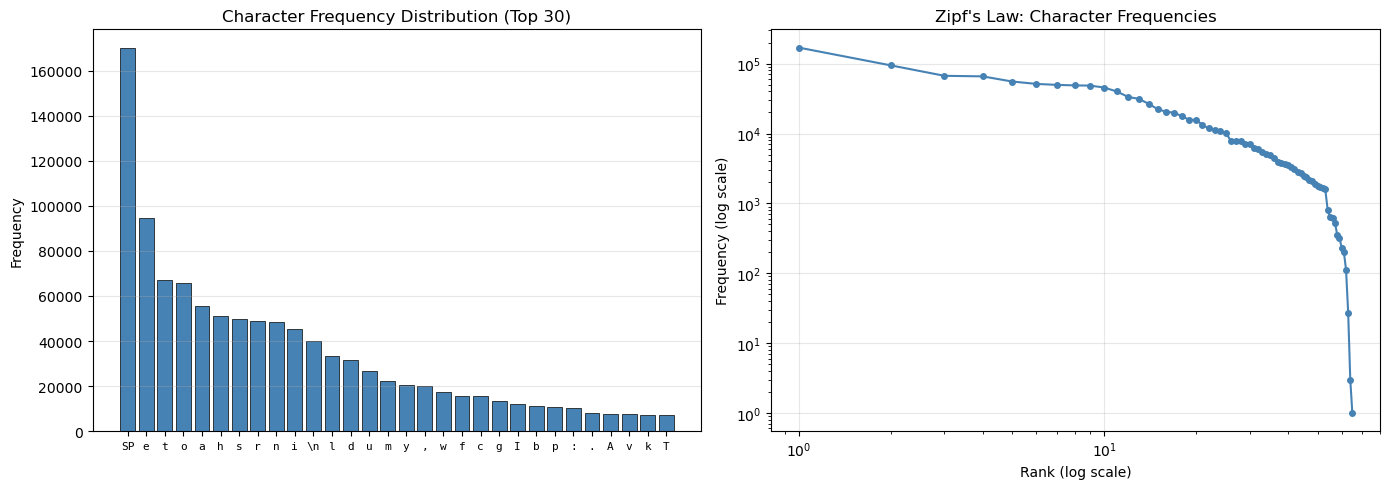

Space and 'e' dominate. The steep Zipf curve means a few characters carry most of the information.
BPE will exploit this: the most frequent *pairs* of these characters get merged first.


In [3]:
# Visualize character frequency and Zipf's law
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of character frequencies
ax = axes[0]
top_chars = char_counts.most_common(30)
chars_display = [repr(c)[1:-1] if c not in ('\n', ' ') else ('\\n' if c == '\n' else 'SP') for c, _ in top_chars]
counts = [c for _, c in top_chars]
bars = ax.bar(range(len(chars_display)), counts, color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(chars_display)))
ax.set_xticklabels(chars_display, fontsize=8, fontfamily='monospace')
ax.set_ylabel('Frequency')
ax.set_title('Character Frequency Distribution (Top 30)')
ax.grid(True, alpha=0.3, axis='y')

# Zipf's law: log-log plot of rank vs frequency
ax = axes[1]
all_counts = sorted(char_counts.values(), reverse=True)
ranks = range(1, len(all_counts) + 1)
ax.loglog(ranks, all_counts, 'o-', color='steelblue', markersize=4)
ax.set_xlabel('Rank (log scale)')
ax.set_ylabel('Frequency (log scale)')
ax.set_title("Zipf's Law: Character Frequencies")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Space and 'e' dominate. The steep Zipf curve means a few characters carry most of the information.")
print("BPE will exploit this: the most frequent *pairs* of these characters get merged first.")

## 2. Character-Level Tokenization (Baseline)

The simplest tokenizer: each unique character gets an integer ID. This is our baseline to compare BPE against.

### Embedding Space View

With character-level tokenization, your embedding matrix is **65 x d_model** — just 65 learnable vectors. That's a tiny embedding space, which seems efficient, but there's a catch:

- The word "the" requires **3 separate embedding lookups** and **3 positions** in the attention window
- The model must learn through *attention alone* that `t` + `h` + `e` appearing together means something different than those letters appearing separately
- For 1.1M characters of Shakespeare, the model sees **1.1M tokens** — that's a very long sequence for attention ($O(n^2)$ cost)

The embedding space is compact but the *sequences are brutally long*.

In [4]:
# Build character-level vocab
chars = sorted(set(text))
char_vocab_size = len(chars)
print(f"Character vocabulary size: {char_vocab_size}")
print(f"Characters: {''.join(chars)}")

# Simple encode/decode
char_to_id = {ch: i for i, ch in enumerate(chars)}
id_to_char = {i: ch for i, ch in enumerate(chars)}

def char_encode(s):
    return [char_to_id[c] for c in s]

def char_decode(ids):
    return "".join(id_to_char[i] for i in ids)

# Test it
sample = "Hello, world!"
encoded = char_encode(sample)
decoded = char_decode(encoded)
print(f"\nOriginal:  {sample}")
print(f"Encoded:   {encoded}")
print(f"Decoded:   {decoded}")
assert decoded == sample, "Round-trip failed!"

# Key metric: sequence length for the full dataset
char_sequence_length = len(text)
print(f"\nSequence length (char-level): {char_sequence_length:,} tokens")
print(f"Vocab size: {char_vocab_size}")

Character vocabulary size: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Original:  Hello, world!
Encoded:   [20, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
Decoded:   Hello, world!

Sequence length (char-level): 1,115,394 tokens
Vocab size: 65


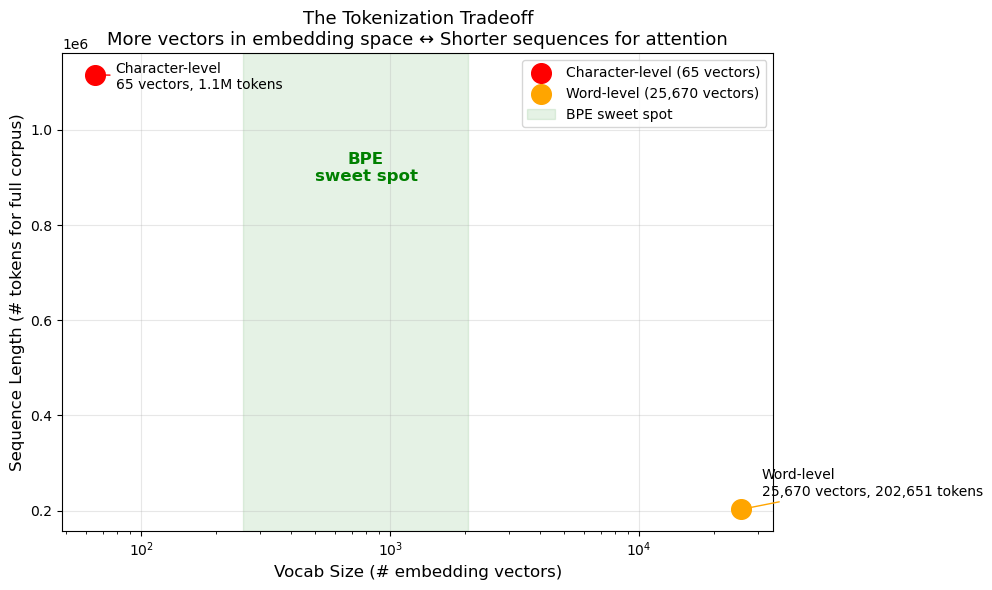

BPE finds the sweet spot: enough vectors to capture common patterns,
but not so many that the embedding table becomes unwieldy.


In [5]:
# Visualize: the embedding space tradeoff
# What happens as we increase vocab size? More vectors, shorter sequences.

fig, ax = plt.subplots(figsize=(10, 6))

# Hypothetical data points for the tradeoff curve
# (We'll fill in real BPE numbers later, but let's set up the intuition)
ax.scatter([65], [len(text)], s=200, color='red', zorder=5, label='Character-level (65 vectors)')
ax.annotate('Character-level\n65 vectors, 1.1M tokens', (65, len(text)),
            textcoords='offset points', xytext=(15, -10), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='red'))

# Rough estimates for word-level
n_words = len(text.split())
n_unique_words = len(set(text.split()))
ax.scatter([n_unique_words], [n_words], s=200, color='orange', zorder=5, label=f'Word-level ({n_unique_words:,} vectors)')
ax.annotate(f'Word-level\n{n_unique_words:,} vectors, {n_words:,} tokens',
            (n_unique_words, n_words),
            textcoords='offset points', xytext=(15, 10), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='orange'))

# BPE sweet spot region
ax.axvspan(256, 2048, alpha=0.1, color='green', label='BPE sweet spot')
ax.text(800, len(text) * 0.8, 'BPE\nsweet spot', fontsize=12, ha='center',
        color='green', fontweight='bold')

ax.set_xlabel('Vocab Size (# embedding vectors)', fontsize=12)
ax.set_ylabel('Sequence Length (# tokens for full corpus)', fontsize=12)
ax.set_title('The Tokenization Tradeoff\nMore vectors in embedding space ↔ Shorter sequences for attention', fontsize=13)
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("BPE finds the sweet spot: enough vectors to capture common patterns,")
print("but not so many that the embedding table becomes unwieldy.")

## 3. BPE Training Algorithm

BPE starts with a byte-level vocab (256 base tokens) and iteratively merges the most frequent adjacent pair into a new token.

### Algorithm:
1. Start with the raw bytes as the initial tokens
2. Count all adjacent token pairs in the corpus
3. Find the most frequent pair
4. Merge that pair into a new token everywhere in the corpus
5. Add the new token to the vocabulary
6. Repeat steps 2-5 until desired vocab size is reached

### Embedding Space Interpretation

Think of each merge as a **decision about what deserves its own embedding vector**:

- **Merge 1** creates the token `e ` (space after 'e'). That pattern is so common (27K occurrences) that giving it its own point in embedding space is efficient — the model doesn't need to waste attention computing `e` + ` ` together.
- **Merge 2** creates `th`. Instead of forcing the model to learn through attention that `t` next to `h` is special, we give `th` its own vector.
- Later merges create `the`, `and`, `you` — whole words that now occupy **single points** in the embedding space.

Each merge trades **one more vector in the embedding table** for **shorter sequences** (fewer attention positions). The algorithm greedily picks the merge that shortens the corpus the most at each step.

In [6]:
import re

def get_pair_counts(token_ids):
    """Count frequency of each adjacent pair in the token sequence."""
    counts = defaultdict(int)
    for i in range(len(token_ids) - 1):
        pair = (token_ids[i], token_ids[i + 1])
        counts[pair] += 1
    return counts


def merge_pair(token_ids, pair, new_id):
    """Replace all occurrences of `pair` in `token_ids` with `new_id`."""
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged


# Quick test
test_ids = [1, 2, 3, 1, 2, 4]
print(f"Before merge: {test_ids}")
print(f"After merging (1,2)->5: {merge_pair(test_ids, (1, 2), 5)}")
print()

# --- Optimized BPE training ---
# The naive approach scans the entire 1M+ token list per merge — way too slow.
# Real BPE implementations (GPT-2, sentencepiece) pre-split the text into "words",
# then operate on (word, count) pairs. This is O(unique_words * avg_word_len) per merge
# instead of O(corpus_length).

def _pre_tokenize(text):
    """
    Split text into chunks that BPE will operate on independently.
    Uses a GPT-2-style regex: splits on whitespace boundaries, punctuation, etc.
    Returns a list of byte-strings.
    """
    # GPT-2 pre-tokenization pattern (simplified)
    pattern = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+""")
    chunks = pattern.findall(text)
    return [chunk.encode("utf-8") for chunk in chunks]


def _get_pair_counts_fast(words):
    """Count pair frequencies across all words, weighted by word count."""
    counts = defaultdict(int)
    for word, freq in words.items():
        for i in range(len(word) - 1):
            counts[(word[i], word[i + 1])] += freq
    return counts


def _merge_word(word, pair, new_id):
    """Merge a pair within a single word (tuple of ints)."""
    new_word = []
    i = 0
    while i < len(word):
        if i < len(word) - 1 and (word[i], word[i + 1]) == pair:
            new_word.append(new_id)
            i += 2
        else:
            new_word.append(word[i])
            i += 1
    return tuple(new_word)


print("Optimized BPE functions loaded.")
print("Key idea: pre-split text into words, then merge within words.")
print("This is ~100x faster because we iterate over unique words, not the full corpus.")

Before merge: [1, 2, 3, 1, 2, 4]
After merging (1,2)->5: [5, 3, 5, 4]

Optimized BPE functions loaded.
Key idea: pre-split text into words, then merge within words.
This is ~100x faster because we iterate over unique words, not the full corpus.


In [7]:
def train_bpe(text, target_vocab_size, verbose=True):
    """
    Train a BPE tokenizer on the given text (optimized).
    
    Uses word-level merging: pre-splits text into words, stores them as
    (word_tuple, count) pairs, and merges within words. This avoids scanning
    the full 1M+ token corpus on every merge.
    
    Returns:
        merges: list of (pair, new_id) tuples in order they were learned
        vocab: dict mapping token_id -> bytes
        seq_length: final sequence length after all merges
    """
    assert target_vocab_size > 256, "Vocab size must be > 256 (base byte tokens)"
    
    chunks = _pre_tokenize(text)
    
    word_counts = defaultdict(int)
    for chunk in chunks:
        word = tuple(chunk)
        word_counts[word] += 1
    
    total_tokens = sum(len(w) * c for w, c in word_counts.items())
    
    vocab = {i: bytes([i]) for i in range(256)}
    merges = []
    num_merges = target_vocab_size - 256
    
    if verbose:
        print(f"Starting BPE training: {total_tokens:,} bytes, {len(word_counts):,} unique words -> {num_merges} merges")
    
    for i in range(num_merges):
        pair_counts = _get_pair_counts_fast(word_counts)
        
        if not pair_counts:
            if verbose:
                print(f"  No more pairs to merge at step {i}")
            break
        
        best_pair = max(pair_counts, key=pair_counts.get)
        best_count = pair_counts[best_pair]
        new_id = 256 + i
        
        new_word_counts = {}
        for word, freq in word_counts.items():
            new_word = _merge_word(word, best_pair, new_id)
            new_word_counts[new_word] = new_word_counts.get(new_word, 0) + freq
        word_counts = new_word_counts
        
        merges.append((best_pair, new_id))
        vocab[new_id] = vocab[best_pair[0]] + vocab[best_pair[1]]
        
        if verbose and (i < 10 or (i + 1) % 50 == 0 or i == num_merges - 1):
            total_tokens = sum(len(w) * c for w, c in word_counts.items())
            token_str = vocab[new_id].decode("utf-8", errors="replace")
            print(
                f"  Merge {i+1:>4}/{num_merges}: "
                f"({best_pair[0]:>4}, {best_pair[1]:>4}) -> {new_id:>4}  "
                f"({repr(token_str):>12}, count={best_count:>6,})  "
                f"seq_len={total_tokens:>8,}"
            )
    
    # Compute final sequence length from word counts (no need to re-encode!)
    final_seq_length = sum(len(w) * c for w, c in word_counts.items())
    
    if verbose:
        compression = len(text.encode('utf-8')) / final_seq_length
        print(f"\nFinal sequence length: {final_seq_length:,}")
        print(f"Compression ratio: {compression:.2f}x")
        print(f"Vocab size: {len(vocab)}")
    
    return merges, vocab, final_seq_length

In [8]:
# Train with a small vocab first to see the merges clearly
merges_small, vocab_small, _ = train_bpe(text, target_vocab_size=300)

Starting BPE training: 1,115,394 bytes, 15,058 unique words -> 44 merges
  Merge    1/44: (  32,  116) ->  256  (        ' t', count=23,835)  seq_len=1,091,559
  Merge    2/44: ( 104,  101) ->  257  (        'he', count=18,203)  seq_len=1,073,356
  Merge    3/44: (  32,   97) ->  258  (        ' a', count=13,541)  seq_len=1,059,815
  Merge    4/44: ( 111,  117) ->  259  (        'ou', count=12,730)  seq_len=1,047,085
  Merge    5/44: (  32,  115) ->  260  (        ' s', count=12,287)  seq_len=1,034,798
  Merge    6/44: (  32,  109) ->  261  (        ' m', count=10,783)  seq_len=1,024,015
  Merge    7/44: ( 105,  110) ->  262  (        'in', count=10,606)  seq_len=1,013,409
  Merge    8/44: (  32,  119) ->  263  (        ' w', count=10,546)  seq_len=1,002,863
  Merge    9/44: ( 114,  101) ->  264  (        're', count= 9,843)  seq_len= 993,020
  Merge   10/44: ( 104,   97) ->  265  (        'ha', count= 9,673)  seq_len= 983,347
  Merge   44/44: ( 262,  103) ->  299  (       'ing', count

In [9]:
# Look at what tokens were learned
print("First 20 learned tokens (beyond single bytes):")
for i, ((a, b), new_id) in enumerate(merges_small[:20]):
    token_bytes = vocab_small[new_id]
    token_str = token_bytes.decode("utf-8", errors="replace")
    print(f"  Token {new_id}: {repr(token_str):>10}  (merged {repr(vocab_small[a].decode('utf-8', errors='replace'))} + {repr(vocab_small[b].decode('utf-8', errors='replace'))})")

print("\n... Notice how common patterns emerge: spaces before words, common letter pairs, then whole words.")

First 20 learned tokens (beyond single bytes):
  Token 256:       ' t'  (merged ' ' + 't')
  Token 257:       'he'  (merged 'h' + 'e')
  Token 258:       ' a'  (merged ' ' + 'a')
  Token 259:       'ou'  (merged 'o' + 'u')
  Token 260:       ' s'  (merged ' ' + 's')
  Token 261:       ' m'  (merged ' ' + 'm')
  Token 262:       'in'  (merged 'i' + 'n')
  Token 263:       ' w'  (merged ' ' + 'w')
  Token 264:       're'  (merged 'r' + 'e')
  Token 265:       'ha'  (merged 'h' + 'a')
  Token 266:       'nd'  (merged 'n' + 'd')
  Token 267:     ' the'  (merged ' t' + 'he')
  Token 268:       ' b'  (merged ' ' + 'b')
  Token 269:       'is'  (merged 'i' + 's')
  Token 270:       'or'  (merged 'o' + 'r')
  Token 271:     '\n\n'  (merged '\n' + '\n')
  Token 272:       ' f'  (merged ' ' + 'f')
  Token 273:       'er'  (merged 'e' + 'r')
  Token 274:       'll'  (merged 'l' + 'l')
  Token 275:       'it'  (merged 'i' + 't')

... Notice how common patterns emerge: spaces before words, common l

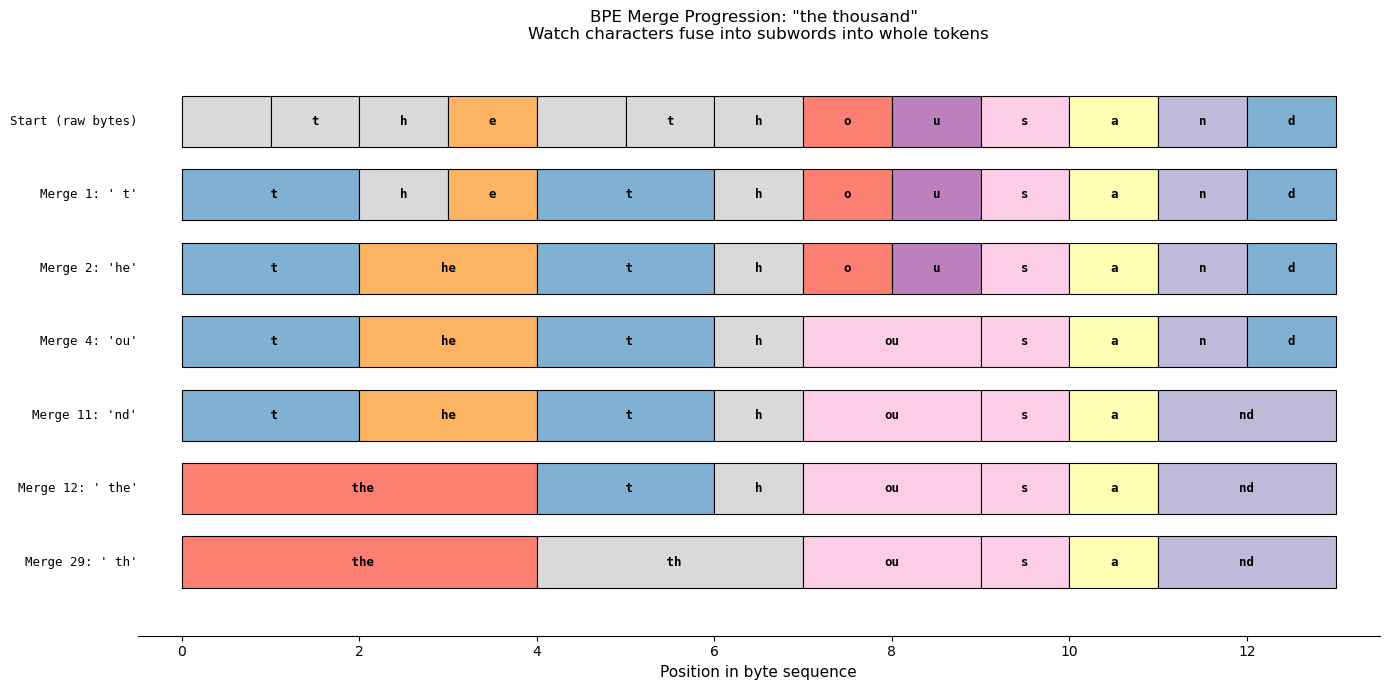

Each row shows the token sequence after another merge is applied.
Characters fuse bottom-to-top: 't'+'h' -> 'th', ' '+'th' -> ' th', ' th'+'e' -> ' the'
In embedding space terms: what started as 13 separate vectors is now represented by fewer, richer vectors.


In [10]:
# Visualize: how a single sentence transforms as merges are applied
# This shows the "merge tree" — how characters fuse into subwords into words

sample_text = " the thousand"
sample_bytes = list(sample_text.encode("utf-8"))

fig, ax = plt.subplots(figsize=(14, 7))

# Track the token sequence at each merge step
stages = [(0, list(sample_bytes), "Start (raw bytes)")]
current = list(sample_bytes)

for i, ((pair_a, pair_b), new_id) in enumerate(merges_small):
    new_seq = merge_pair(current, (pair_a, pair_b), new_id)
    if len(new_seq) < len(current):  # a merge happened in our sample
        token_str = vocab_small[new_id].decode("utf-8", errors="replace")
        stages.append((i + 1, list(new_seq), f"Merge {i+1}: {repr(token_str)}"))
    current = new_seq

# Plot each stage as a row of colored boxes
cmap = plt.cm.Set3
n_stages = len(stages)
box_height = 0.7

for row, (merge_num, seq, label) in enumerate(stages):
    y = n_stages - 1 - row
    x_offset = 0
    for j, token_id in enumerate(seq):
        token_bytes = vocab_small[token_id]
        token_text = token_bytes.decode("utf-8", errors="replace")
        display = repr(token_text)[1:-1]  # strip quotes
        
        # Width proportional to token length in bytes
        w = len(token_bytes)
        color = cmap(token_id % 12 / 12)
        
        rect = plt.Rectangle((x_offset, y - box_height/2), w, box_height,
                              facecolor=color, edgecolor='black', linewidth=0.8)
        ax.add_patch(rect)
        ax.text(x_offset + w/2, y, display, ha='center', va='center', fontsize=9,
                fontfamily='monospace', fontweight='bold')
        x_offset += w
    
    ax.text(-0.5, y, label, ha='right', va='center', fontsize=9, fontfamily='monospace')

ax.set_xlim(-0.5, len(sample_bytes) + 0.5)
ax.set_ylim(-1, n_stages)
ax.set_xlabel('Position in byte sequence', fontsize=11)
ax.set_title(f'BPE Merge Progression: "{sample_text.strip()}"  \n'
             'Watch characters fuse into subwords into whole tokens',
             fontsize=12)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

print("Each row shows the token sequence after another merge is applied.")
print("Characters fuse bottom-to-top: 't'+'h' -> 'th', ' '+'th' -> ' th', ' th'+'e' -> ' the'")
print("In embedding space terms: what started as 13 separate vectors is now represented by fewer, richer vectors.")

## 4. BPE Encode and Decode

Now we need to be able to *use* our trained tokenizer:
- **Encode**: given new text, apply the learned merges in order to produce token IDs
- **Decode**: given token IDs, look up the bytes for each token and concatenate

In [11]:
class BPETokenizer:
    """Byte-Pair Encoding tokenizer."""
    
    def __init__(self, merges, vocab):
        """
        Args:
            merges: list of ((id_a, id_b), new_id) in the order they were learned
            vocab: dict mapping token_id -> bytes
        """
        self.merges = merges
        self.vocab = vocab
        # Build a lookup: pair -> new_id for fast encoding
        self.merge_map = {pair: new_id for pair, new_id in merges}
    
    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def encode(self, text):
        """
        Encode text to token IDs by applying learned merges.
        
        Pre-tokenizes into words (same as training), then applies merges
        within each word. Much faster than scanning the whole sequence
        per merge.
        """
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)  # list of byte values (ints)
            # Apply merges in order within this word
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids
    
    def decode(self, token_ids):
        """
        Decode token IDs back to text.
        Simply look up the bytes for each token and concatenate.
        """
        byte_sequence = b"".join(self.vocab[id] for id in token_ids)
        return byte_sequence.decode("utf-8", errors="replace")
    
    def save(self, path):
        """Save tokenizer to a JSON file."""
        data = {
            "merges": [[[int(a), int(b)], int(new_id)] for (a, b), new_id in self.merges],
            "vocab": {str(k): list(v) for k, v in self.vocab.items()},
        }
        with open(path, "w") as f:
            json.dump(data, f)
        print(f"Saved tokenizer to {path} (vocab_size={self.vocab_size})")
    
    @classmethod
    def load(cls, path):
        """Load tokenizer from a JSON file."""
        with open(path, "r") as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        print(f"Loaded tokenizer from {path} (vocab_size={len(vocab)})")
        return cls(merges, vocab)

In [12]:
# Test the tokenizer
tokenizer_small = BPETokenizer(merges_small, vocab_small)

test_strings = [
    "Hello, world!",
    "To be, or not to be, that is the question.",
    "ROMEO: What light through yonder window breaks?",
]

for s in test_strings:
    encoded = tokenizer_small.encode(s)
    decoded = tokenizer_small.decode(encoded)
    tokens_str = [tokenizer_small.vocab[id].decode('utf-8', errors='replace') for id in encoded]
    print(f"Text:    {s}")
    print(f"Tokens:  {tokens_str}")
    print(f"IDs:     {encoded}")
    print(f"Decoded: {decoded}")
    assert decoded == s, f"Round-trip failed for: {s}"
    print(f"  -> {len(s.encode('utf-8'))} bytes -> {len(encoded)} tokens ({len(s.encode('utf-8'))/len(encoded):.1f}x compression)")
    print()

Text:    Hello, world!
Tokens:  ['H', 'e', 'll', 'o', ',', ' w', 'or', 'l', 'd', '!']
IDs:     [72, 101, 274, 111, 44, 263, 270, 108, 100, 33]
Decoded: Hello, world!
  -> 13 bytes -> 10 tokens (1.3x compression)

Text:    To be, or not to be, that is the question.
Tokens:  ['T', 'o', ' b', 'e', ',', ' ', 'or', ' n', 'ot', ' to', ' b', 'e', ',', ' t', 'hat', ' ', 'is', ' the', ' ', 'q', 'u', 'es', 't', 'i', 'on', '.']
IDs:     [84, 111, 268, 101, 44, 32, 270, 281, 295, 288, 268, 101, 44, 256, 291, 32, 269, 267, 32, 113, 117, 279, 116, 105, 276, 46]
Decoded: To be, or not to be, that is the question.
  -> 42 bytes -> 26 tokens (1.6x compression)

Text:    ROMEO: What light through yonder window breaks?
Tokens:  ['R', 'O', 'M', 'E', 'O', ':', ' ', 'W', 'hat', ' l', 'i', 'g', 'h', 't', ' th', 'r', 'ou', 'g', 'h', ' y', 'o', 'nd', 'er', ' w', 'in', 'd', 'ow', ' b', 're', 'a', 'k', 's', '?']
IDs:     [82, 79, 77, 69, 79, 58, 32, 87, 291, 282, 105, 103, 104, 116, 284, 114, 259, 103, 104, 283,

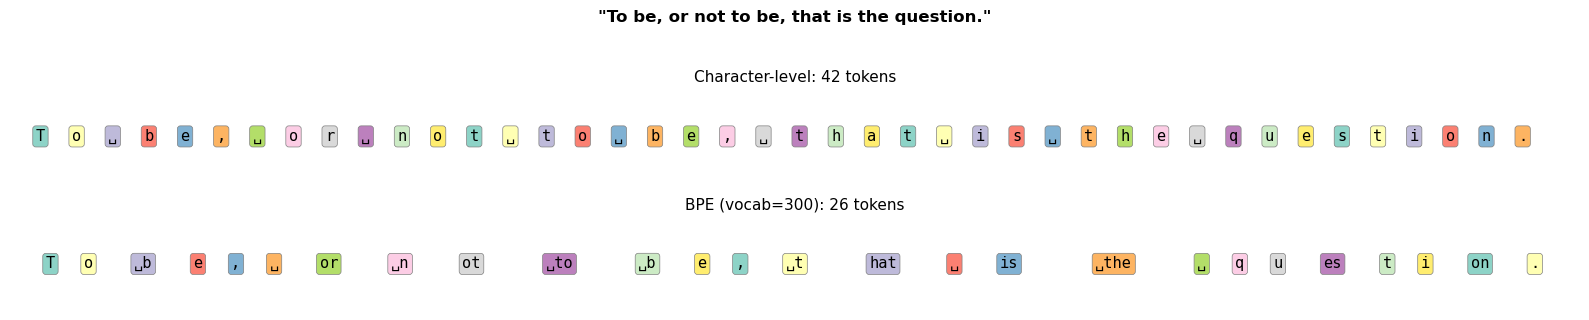

Character-level: 42 tokens (each character = 1 embedding vector lookup)
BPE-300: 26 tokens (common patterns like 'the', 'or', 'not' get single vectors)
That's 1.6x fewer positions for attention to process!


In [13]:
# Visualize: color-coded tokenization comparison
# Show how the same text gets split differently at different vocab sizes

sample = "To be, or not to be, that is the question."

# Color-code tokens for the small tokenizer
encoded = tokenizer_small.encode(sample)
tokens = [tokenizer_small.vocab[id].decode('utf-8', errors='replace') for id in encoded]

fig, axes = plt.subplots(2, 1, figsize=(16, 3))

colors = plt.cm.Set3(np.linspace(0, 1, 12))

# Character-level
ax = axes[0]
x = 0
for i, ch in enumerate(sample):
    color = colors[i % len(colors)]
    display = ch if ch != ' ' else '\u2423'  # visible space
    ax.text(x, 0.5, display, fontsize=11, fontfamily='monospace',
            ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor=color, edgecolor='gray', linewidth=0.5))
    x += 0.7
ax.set_xlim(-0.5, x + 0.5)
ax.set_ylim(0, 1)
ax.set_title(f'Character-level: {len(sample)} tokens', fontsize=11)
ax.axis('off')

# BPE-300
ax = axes[1]
x = 0
for i, tok in enumerate(tokens):
    color = colors[i % len(colors)]
    display = tok.replace(' ', '\u2423')
    w = len(tok) * 0.7
    ax.text(x + w/2, 0.5, display, fontsize=11, fontfamily='monospace',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor=color, edgecolor='gray', linewidth=0.5))
    x += w + 0.1
ax.set_xlim(-0.5, x + 0.5)
ax.set_ylim(0, 1)
ax.set_title(f'BPE (vocab=300): {len(tokens)} tokens', fontsize=11)
ax.axis('off')

plt.suptitle(f'"{sample}"', fontsize=12, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print(f"Character-level: {len(sample)} tokens (each character = 1 embedding vector lookup)")
print(f"BPE-300: {len(tokens)} tokens (common patterns like 'the', 'or', 'not' get single vectors)")
print(f"That's {len(sample)/len(tokens):.1f}x fewer positions for attention to process!")

## 5. Experiment: Vocab Size vs Compression

### The Embedding Table Budget

Here's the key question: **how many embedding vectors should we allocate?**

- **Larger vocab** (more merges) = more vectors in the embedding table, but shorter sequences. The model pays in *parameter count* (more rows in the embedding matrix) but gains in *sequence efficiency* (fewer attention positions).
- **Smaller vocab** (fewer merges) = fewer vectors, but longer sequences. Cheaper embedding table, but attention has to do more work over longer distances.

In practice, most LLMs use 32K-100K vocab:
- GPT-2: 50,257 tokens
- LLaMA: 32,000 tokens  
- GPT-4: ~100,000 tokens

For our tiny model, even 512 tokens gives meaningful compression. Let's measure the tradeoff directly.

In [14]:
vocab_sizes = [300, 512, 1024]
results = {}

raw_byte_length = len(text.encode("utf-8"))
print(f"Raw byte length: {raw_byte_length:,}\n")

for vs in vocab_sizes:
    print(f"{'='*60}")
    print(f"Training BPE with vocab_size={vs}")
    print(f"{'='*60}")
    merges_v, vocab_v, seq_length = train_bpe(text, target_vocab_size=vs, verbose=True)
    tok = BPETokenizer(merges_v, vocab_v)
    
    # Use seq_length from training directly — no need to re-encode the full text!
    # (Re-encoding 1.1M chars with 256+ merges was what caused the hang.)
    compression = raw_byte_length / seq_length
    
    results[vs] = {
        "seq_length": seq_length,
        "compression": compression,
        "tokenizer": tok,
    }
    print()

Raw byte length: 1,115,394

Training BPE with vocab_size=300
Starting BPE training: 1,115,394 bytes, 15,058 unique words -> 44 merges
  Merge    1/44: (  32,  116) ->  256  (        ' t', count=23,835)  seq_len=1,091,559
  Merge    2/44: ( 104,  101) ->  257  (        'he', count=18,203)  seq_len=1,073,356
  Merge    3/44: (  32,   97) ->  258  (        ' a', count=13,541)  seq_len=1,059,815
  Merge    4/44: ( 111,  117) ->  259  (        'ou', count=12,730)  seq_len=1,047,085
  Merge    5/44: (  32,  115) ->  260  (        ' s', count=12,287)  seq_len=1,034,798
  Merge    6/44: (  32,  109) ->  261  (        ' m', count=10,783)  seq_len=1,024,015
  Merge    7/44: ( 105,  110) ->  262  (        'in', count=10,606)  seq_len=1,013,409
  Merge    8/44: (  32,  119) ->  263  (        ' w', count=10,546)  seq_len=1,002,863
  Merge    9/44: ( 114,  101) ->  264  (        're', count= 9,843)  seq_len= 993,020
  Merge   10/44: ( 104,   97) ->  265  (        'ha', count= 9,673)  seq_len= 983,34

In [15]:
# Summary table
print(f"{'Vocab Size':>12} {'Seq Length':>12} {'Compression':>12} {'Bytes/Token':>12}")
print("-" * 52)

# Character-level baseline
print(f"{'char(' + str(char_vocab_size) + ')':>12} {len(text):>12,} {1.0:>12.2f}x {1.0:>12.2f}")

for vs in vocab_sizes:
    r = results[vs]
    bytes_per_token = raw_byte_length / r['seq_length']
    print(f"{vs:>12} {r['seq_length']:>12,} {r['compression']:>12.2f}x {bytes_per_token:>12.2f}")

print("\nNotice: each doubling of vocab size gives diminishing returns on compression.")
print("This is why most LLMs use vocab sizes of 32k-100k as a sweet spot.")

  Vocab Size   Seq Length  Compression  Bytes/Token
----------------------------------------------------
    char(65)    1,115,394         1.00x         1.00
         300      799,134         1.40x         1.40
         512      568,603         1.96x         1.96
        1024      452,675         2.46x         2.46

Notice: each doubling of vocab size gives diminishing returns on compression.
This is why most LLMs use vocab sizes of 32k-100k as a sweet spot.


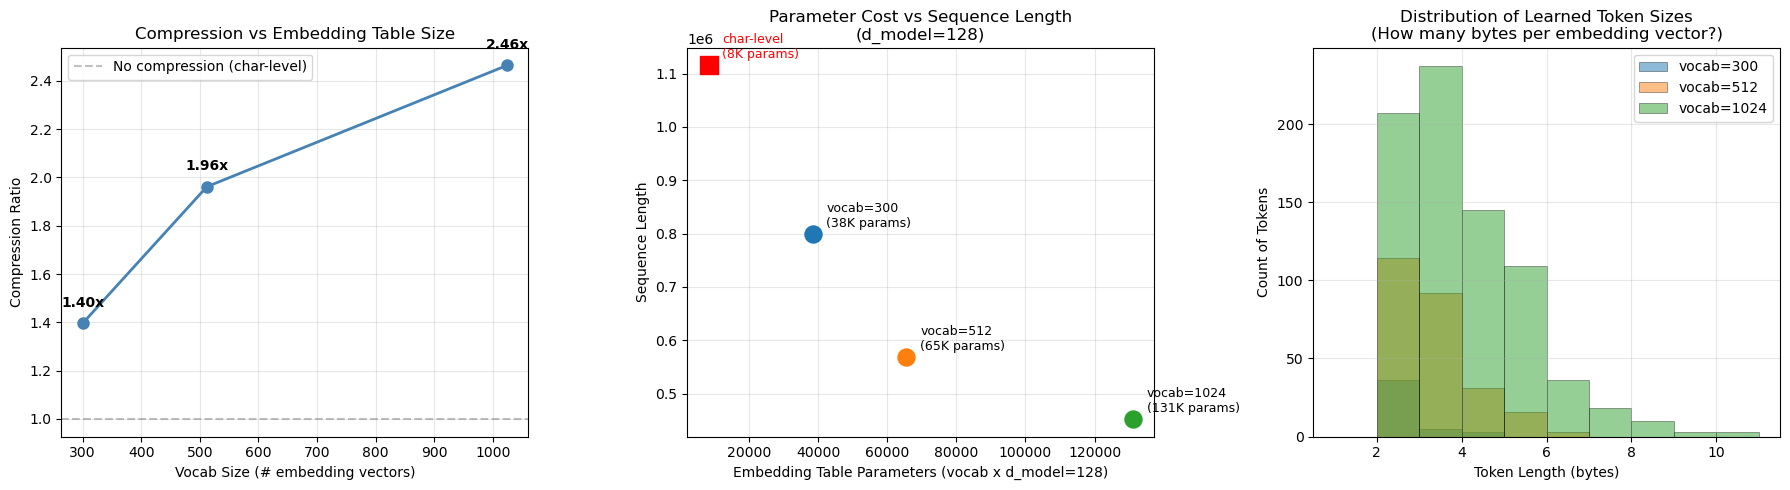

Left: More merges = better compression, but diminishing returns.
Middle: Each vocab increase costs embedding parameters but saves sequence length.
  At d_model=128: vocab 512 costs 65K params but cuts sequence by ~50%
Right: Larger vocabs create longer tokens — each embedding vector 'means' more.


In [16]:
# Visualize: compression ratio + token length distribution across vocab sizes

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Compression ratio vs vocab size ---
ax = axes[0]
vs_list = sorted(results.keys())
compressions = [results[vs]["compression"] for vs in vs_list]
ax.plot(vs_list, compressions, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='No compression (char-level)')
ax.set_xlabel('Vocab Size (# embedding vectors)')
ax.set_ylabel('Compression Ratio')
ax.set_title('Compression vs Embedding Table Size')
ax.legend()
ax.grid(True, alpha=0.3)

# Annotate diminishing returns
for vs, comp in zip(vs_list, compressions):
    ax.annotate(f'{comp:.2f}x', (vs, comp), textcoords="offset points",
                xytext=(0, 12), ha='center', fontsize=10, fontweight='bold')

# --- Plot 2: Embedding table cost (params) vs sequence savings ---
ax = axes[1]
d_model = 128  # our tiny model
for vs in vs_list:
    embed_params = vs * d_model
    seq_len = results[vs]["seq_length"]
    ax.scatter(embed_params, seq_len, s=150, zorder=5)
    ax.annotate(f'vocab={vs}\n({embed_params//1000:.0f}K params)',
                (embed_params, seq_len), textcoords="offset points",
                xytext=(10, 5), fontsize=9)

# Add char-level baseline
char_params = 65 * d_model
ax.scatter(char_params, len(text), s=150, marker='s', color='red', zorder=5)
ax.annotate(f'char-level\n({char_params//1000:.0f}K params)', 
            (char_params, len(text)), textcoords="offset points",
            xytext=(10, 5), fontsize=9, color='red')

ax.set_xlabel(f'Embedding Table Parameters (vocab x d_model={d_model})')
ax.set_ylabel('Sequence Length')
ax.set_title(f'Parameter Cost vs Sequence Length\n(d_model={d_model})')
ax.grid(True, alpha=0.3)

# --- Plot 3: Token byte-length distribution ---
ax = axes[2]
for vs in vs_list:
    tok = results[vs]["tokenizer"]
    # Get byte-lengths of all tokens that appear in the vocab above 256
    token_lengths = []
    for token_id in range(256, tok.vocab_size):
        token_lengths.append(len(tok.vocab[token_id]))
    ax.hist(token_lengths, bins=range(1, max(token_lengths) + 2), 
            alpha=0.5, label=f'vocab={vs}', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Token Length (bytes)')
ax.set_ylabel('Count of Tokens')
ax.set_title('Distribution of Learned Token Sizes\n(How many bytes per embedding vector?)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Left: More merges = better compression, but diminishing returns.")
print("Middle: Each vocab increase costs embedding parameters but saves sequence length.")
print(f"  At d_model={d_model}: vocab 512 costs {512*d_model//1000}K params but cuts sequence by ~50%")
print("Right: Larger vocabs create longer tokens — each embedding vector 'means' more.")

## 6. Save the Tokenizer

We'll use the vocab_size=512 tokenizer for our model training in later notebooks. It gives reasonable compression while keeping the vocab small enough for a tiny model.

In [17]:
# Use the 512-vocab tokenizer as our default
default_tokenizer = results[512]["tokenizer"]

# Save it
tokenizer_path = os.path.join("..", "data", "bpe_tokenizer.json")
default_tokenizer.save(tokenizer_path)

# Verify we can reload it
loaded_tok = BPETokenizer.load(tokenizer_path)
test = "Shall I compare thee to a summer's day?"
assert loaded_tok.decode(loaded_tok.encode(test)) == test
print(f"\nRound-trip verification passed!")
print(f"Vocab size: {loaded_tok.vocab_size}")
print(f"\nSample encoding:")
enc = loaded_tok.encode(test)
tokens = [loaded_tok.vocab[id].decode('utf-8', errors='replace') for id in enc]
print(f"  Text:   {test}")
print(f"  Tokens: {tokens}")
print(f"  ({len(test.encode('utf-8'))} bytes -> {len(enc)} tokens)")

Saved tokenizer to ../data/bpe_tokenizer.json (vocab_size=512)
Loaded tokenizer from ../data/bpe_tokenizer.json (vocab_size=512)

Round-trip verification passed!
Vocab size: 512

Sample encoding:
  Text:   Shall I compare thee to a summer's day?
  Tokens: ['S', 'ha', 'll', ' I', ' com', 'p', 'are', ' thee', ' to', ' a', ' su', 'm', 'm', 'er', "'s", ' d', 'ay', '?']
  (39 bytes -> 18 tokens)


## Summary

**What we built:**
- A BPE tokenizer from scratch that learns subword tokens from data
- Encode (text -> token IDs) and decode (token IDs -> text) functions
- Save/load so we can reuse this tokenizer in all future notebooks

**Key takeaways:**
- BPE is greedy: it always merges the most frequent pair next
- Early merges capture common byte pairs (spaces, `e `, `th`), later merges capture whole words
- Vocab size controls a tradeoff: larger vocab = shorter sequences but bigger embedding table
- For our tiny model, vocab_size=512 is a good starting point

### The Embedding Space Perspective (Summary)

| Concept | Tokenizer Control |
|---|---|
| **# of vectors** in the embedding table | `vocab_size` (set by number of BPE merges) |
| **What each vector represents** | Determined by which merges were learned (data-driven) |
| **Sequence length** for attention | Inversely proportional to compression ratio |
| **Embedding table parameters** | `vocab_size x d_model` |
| **Semantic granularity** | Small vocab = fine-grained (chars), large vocab = coarse (words) |

The tokenizer is the **first architectural decision** in any LLM and it's irreversible — once you pick a tokenization, the entire embedding space and attention structure follows from it. The model can only reason about units the tokenizer gives it.

Think of it this way: if `"the"` is a single token, the model gets `the` as a single vector and can learn its meaning directly. If it's three tokens `t`, `h`, `e`, the model must *discover through attention* that these three vectors together mean something specific. BPE automates this decision by giving dedicated vectors to the most frequent patterns.

**Next: Notebook 2** - We'll use this tokenizer to build the simplest possible language model (bigram baseline) and see how these token IDs become actual embedding vectors.